In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

In [2]:
import matplotlib.backends.backend_pdf

In [3]:
import geopandas as gpd

In [4]:
import matplotlib as mpl

In [5]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches

# LSFF: Generate data coverage maps stratified by nutrient

In [6]:
## load legal combos
import pickle
data_prep_dir = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/inputs/'

with open(data_prep_dir + 'lsff_vehicle_nutrient_pairs.pickle', 'rb') as handle:
    vehicle_nutrient_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_country_vehicle_pairs.pickle', 'rb') as handle:
    country_vehicle_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_vehicle_country_pairs.pickle', 'rb') as handle:
    vehicle_country_map = pickle.load(handle)

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.name = world.name.astype(str)

world.loc[world.name=="Dem. Rep. Congo",'name'] = 'Democratic Republic of the Congo'
world.loc[world.name=="Tanzania",'name'] = 'United Republic of Tanzania'
world = world.rename(columns={'name':'location_name'})

In [8]:
data_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/outputs/data_counts_nutrient_na.csv'

df = pd.read_csv(data_path)
df.value_description.unique()

array(['percent of market covered by fortified product',
       'percent of population eating fortified vehicle',
       'percent of population eating industrially produced vehicle',
       'percent of population eating vehicle',
       'percent of vehicle that is fortified',
       'percent of vehicle that is industrially produced'], dtype=object)

In [9]:
data_full_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/outputs/data_counts_full.csv'
df_full = pd.read_csv(data_full_path)
df_full = world[['location_name','geometry']].merge(df_full, on = 'location_name', how = 'right')

In [10]:
df.head()

location_name      vehicle  \
0        Angola  maize flour   
1        Angola  maize flour   
2        Angola  maize flour   
3        Angola  maize flour   
4        Angola  maize flour   

                                   value_description  n_data_points  \
0     percent of market covered by fortified product              0   
1     percent of population eating fortified vehicle              0   
2  percent of population eating industrially prod...              0   
3               percent of population eating vehicle              0   
4               percent of vehicle that is fortified              0   

   mean_mean value_means  
0        NaN       [nan]  
1        NaN       [nan]  
2        NaN       [nan]  
3        NaN       [nan]  
4        NaN       [nan]

In [11]:
df_full.head()

location_name  \
0  United Republic of Tanzania   
1  United Republic of Tanzania   
2  United Republic of Tanzania   
3  United Republic of Tanzania   
4  United Republic of Tanzania   

                                            geometry      vehicle  \
0  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  maize flour   
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  maize flour   
2  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  maize flour   
3  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  maize flour   
4  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  maize flour   

      nutrient                               value_description  n_data_points  \
0   folic acid  percent of market covered by fortified product              0   
1         iron  percent of market covered by fortified product              0   
2    vitamin a  percent of market covered by fortified product              0   
3   vitamin b1  percent of market covered by fortified product              0   
4  vitamin b12  percent of market covered by fortified product              0   

   mean_mean value_means  
0        NaN       [nan]  
1        NaN       [nan]  
2        NaN       [nan]  
3        NaN       [nan]  
4        NaN       [nan]

In [12]:
def pull_fort_legislation():
    fort_legislation_path = '/snfs1/Project/simulation_science/lsff/01_LSFF_GBD_2019/fortification_legislation_data.csv'
    df = pd.read_csv(fort_legislation_path, encoding = 'iso-8859-1')

    nutrient_rename = {i:i.lower() for i in df.Micronutrient.unique()}
    vehicle_rename = {i:i.lower() for i in df.Vehicle.unique()}
    loc_rename = {'Cote d\x92Ivoire':"Côte d'Ivoire", 'Tanzania':"United Republic of Tanzania", 'Viet Nam':"Vietnam"}

    df['nutrient'] = df.Micronutrient.map(nutrient_rename)
    df['vehicle'] = df.Vehicle.map(vehicle_rename)
    df['location_name'] = df.Country
    df.loc[df.location_name.isin(loc_rename.keys()),'location_name'] = df.location_name.map(loc_rename)
    df.rename(columns={'Standard':'standard'}, inplace=True)

    return df[['location_name','vehicle','nutrient','standard']]

fort_legislation = pull_fort_legislation()

In [11]:
# for the variable "percent of population eating fortified vehicle":
    # for each vehicle:
        # X = all nutrients applicable to vehiclce.
        # for each nutrient_i in X:
            # you want to plot an outline of all countries in Africa and Asia.
            
            # you then want a list (A) of all countries where we've extracted a val for nutrient_i
            # and a list (B) of all countries with a val for nutrient_j in X that DONT have a val for nutrient_i
            # and a list (C) of all locations where we believe vehicle is not being fortified with nutrient_i
            
            # you then want to plot, in full color, countries (A)
            # in striped color, countries (B\C)
            # in gray, all countries in (A u B)^C

In [39]:
data = pd.pivot_table(df, values = 'mean_mean', 
                      index=['location_name','value_description'], 
                      columns = 'vehicle',dropna=False).reset_index() #long on loc/nutr, wide on vehicle

data = world.merge(data, on = ['location_name'], how = 'right')
data.rename(columns={'maize flour':'maize_flour','wheat flour':'wheat_flour'}, inplace=True)

data['believe_zero'] = 0

In [135]:
def map_data_coverage(value_d, vehicle, nutrient_i, n_colors):
    # set plot title
    vehicle_name = vehicle.replace(" ","_")
    var_label = f'percent of {vehicle} that is fortified with {nutrient_i}'
    
    # initialize plot
    fig, ax = plt.subplots(figsize=(30,10))
    ax.set_aspect('equal')
    ax.set_title(f'Data coverage: {var_label}', fontsize = 24)
    ax.set_axis_off()

    # all country outlines
    base = world[world.continent.isin(['Africa','Asia'])].plot(ax=ax, color='white', edgecolor='gray')
    
    # PARTITION COUNTRIES -------------------------------------------------------------------
    # all countries for which we're considering vehicle
    target_countries = vehicle_country_map[vehicle]
    
    # all countries that have nutrient_i
    know_nutrient_i = df_full[(df_full.value_description==value_d) & 
        (df_full.vehicle==vehicle) & 
        (df_full.nutrient==nutrient_i) & 
        (df_full.mean_mean.notna())].location_name.unique().tolist()
    know_nutrient_i = [loc for loc in know_nutrient_i if loc in target_countries] # precaution; should check/remove this
    
    # all countries that have nutrient_j, j!=i
    know_nutrient_j = df_full[(df_full.value_description==value_d) & 
        (df_full.vehicle==vehicle) & 
        (df_full.nutrient!=nutrient_i) & 
        (df_full.mean_mean.notna())].location_name.unique().tolist()
    know_nutrient_j = [loc for loc in know_nutrient_j if loc in target_countries] # precaution; should check/remove this\
    
    # all countries for that have nutrient_j and DONT have nutrient_i
    guessing_nutrient_i = [loc for loc in know_nutrient_j if loc not in know_nutrient_i]
    
    # countries we're modeling, where there is no evidence of fortification legislation
    believe_zero = fort_legislation[(fort_legislation.vehicle==vehicle)&
                            (fort_legislation.nutrient==nutrient_i)&
                            (fort_legislation.standard!="Mandatory")].location_name.tolist()
    believe_zero = [loc for loc in believe_zero if loc in target_countries]
    
    # countries where we'll guess zero, because we there is no fort legisl. and
    # we have no data for nutrient_i or any nutrient_j!=i
    guessing_zero = [loc for loc in believe_zero if loc not in know_nutrient_i + guessing_nutrient_i]
    
    # countries where there is some fortification legislation, but we have no data
    no_data_no_guesses = [loc for loc in target_countries if loc not in know_nutrient_i + guessing_nutrient_i + guessing_zero]
    
    # -----------------------------------------------------------------------------------------
    
    # set colorbar
    cmap = cm.get_cmap('summer_r')(np.linspace(0,1,n_colors-1)) #colors for nonzero vals
    pink = np.array([[250/256, 122/256, 179/256, 1]]) #zero color
    cmap =  np.concatenate([pink, cmap])
    cmap = ListedColormap(cmap)
    
    ticks = [0,1] + [int(i) for i in np.arange(0,101,100/(n_colors-1))][1:]
    norm = mpl.colors.BoundaryNorm(ticks, cmap.N)
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        ax=base,
                        spacing = 'uniform')

    

    # plot countries where know_nutrient_i, full color  
    norm = mpl.colors.BoundaryNorm(ticks, cmap.N)
    main = df_full[(df_full.value_description==value_d) & 
        (df_full.vehicle==vehicle) & 
        (df_full.nutrient==nutrient_i) & 
        (df_full.mean_mean.notna()) &
                   (df_full.location_name.isin(target_countries))].plot(ax = base,
                                          column = 'mean_mean',
                                          cmap = cmap,
                                          edgecolor = 'gray')
        
    # plot countries where guessing_nutrient_i, hashed color
    secondary = data[(data.value_description==value_d) &
                     (data.location_name.isin(guessing_nutrient_i))].plot(ax=base,
                                                                      column = vehicle_name,
                                                                      cmap = cmap,
                                                                      hatch = '///',
                                                                      alpha = 0.9,
                                                                      edgecolor = 'gray')
    
    # plot countries where guessing zero, hashed color 
    tertiary = data[(data.value_description==value_d) &
                     (data.location_name.isin(guessing_zero))].plot(ax=base,
                                                                      column = 'believe_zero',
                                                                      cmap = cmap,
                                                                      hatch = '///',#'oo',
                                                                      alpha = 0.9,
                                                                      edgecolor = 'gray')
    
    
    # plot countries we want to model where we have no data
    missing = world[world.location_name.isin(no_data_no_guesses)].plot(ax=base,
                                                                color='gray',
                                                                edgecolor='gray')
#     print(f'target countries: {target_countries}')
#     print(f'know_nutrient_i: {know_nutrient_i}')
#     print(f'guessing_nutrient_i: {guessing_nutrient_i}')
#     print(f'guessing_zero: {guessing_zero}')
#     print(f'no_data_no_guesses: {no_data_no_guesses}')

    green = (0.49803922,0.74901961,0.4,1.0) #RGBA
    green = (0.74901961, 0.8745098 , 0.4,1.0)
    green = (0.24705882, 0.62352941, 0.4,1)
    a_val = 1
    have_data = mpatches.Patch(facecolor=green,label='Data')
    inferred = mpatches.Patch(facecolor=green,hatch='////', label='Inferred')
    unknown = mpatches.Patch(facecolor='gray',label='Unknown')
    not_modeled = mpatches.Patch(facecolor='white', edgecolor = 'gray', label='Not modeled')

#     fig,(ax) = plt.subplots()

    plt.legend(handles = [have_data,inferred,unknown,not_modeled], loc=4, fontsize=12, handlelength=4)

    
    return fig

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been d

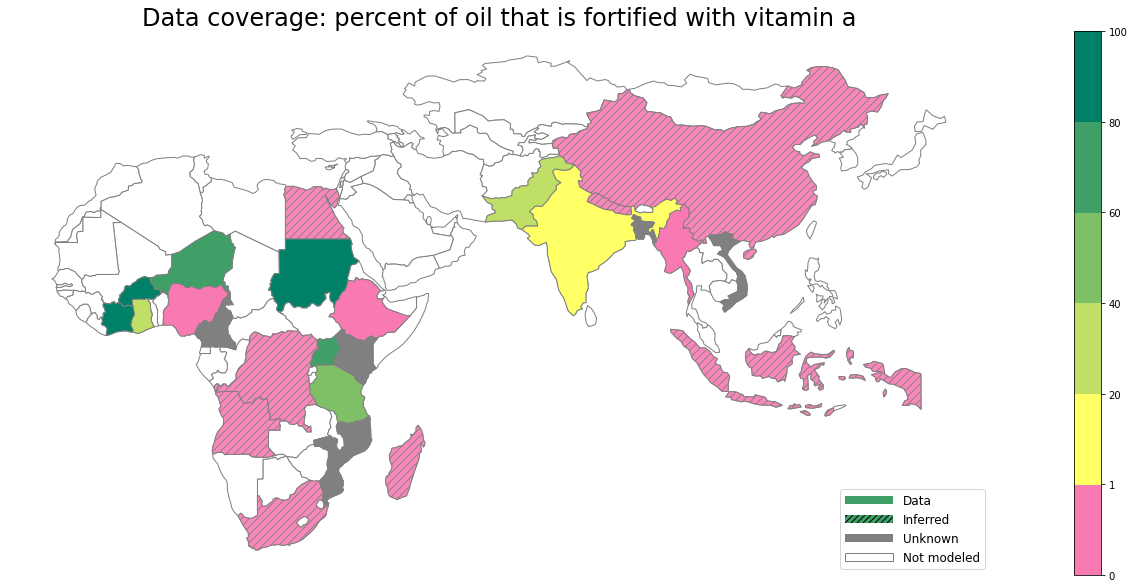

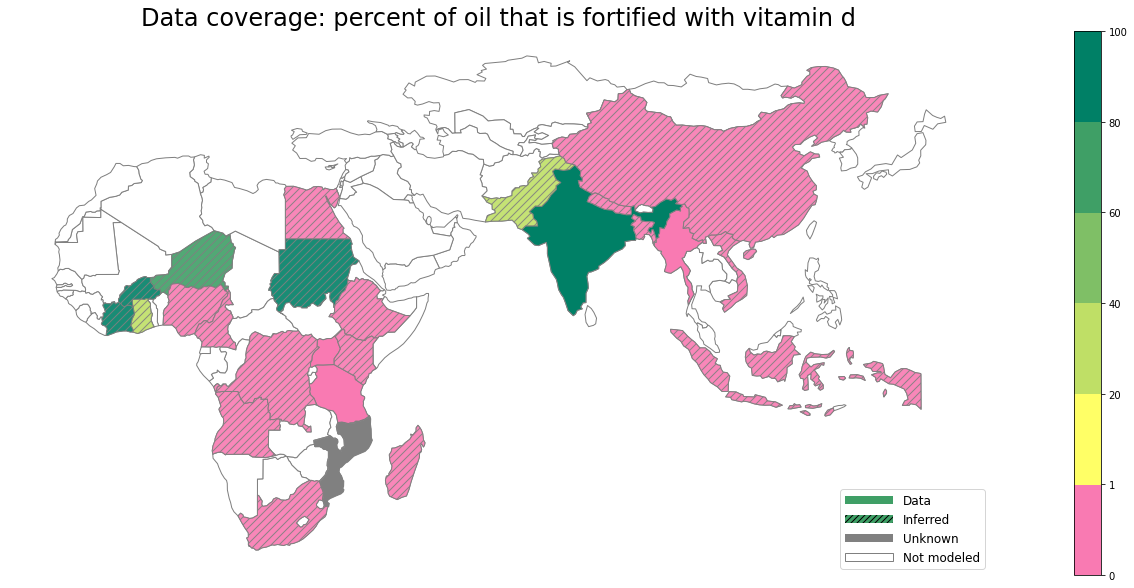

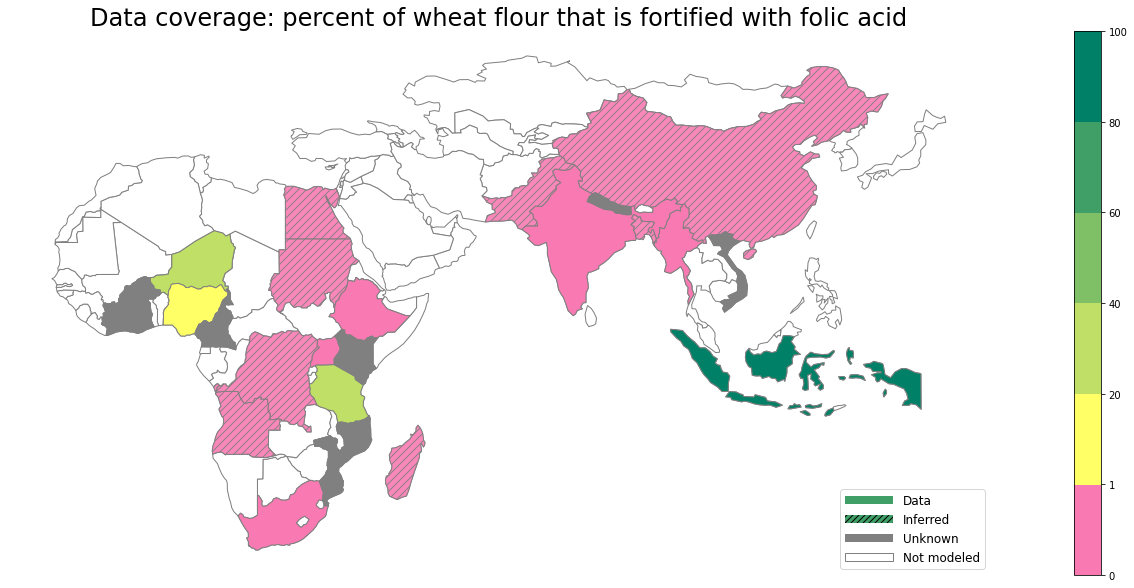

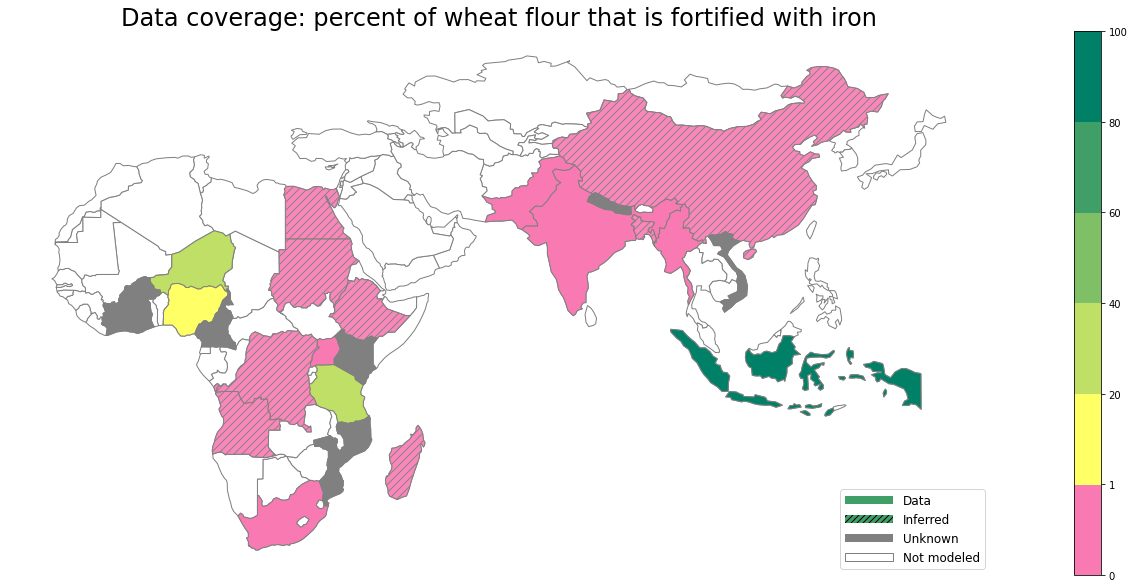

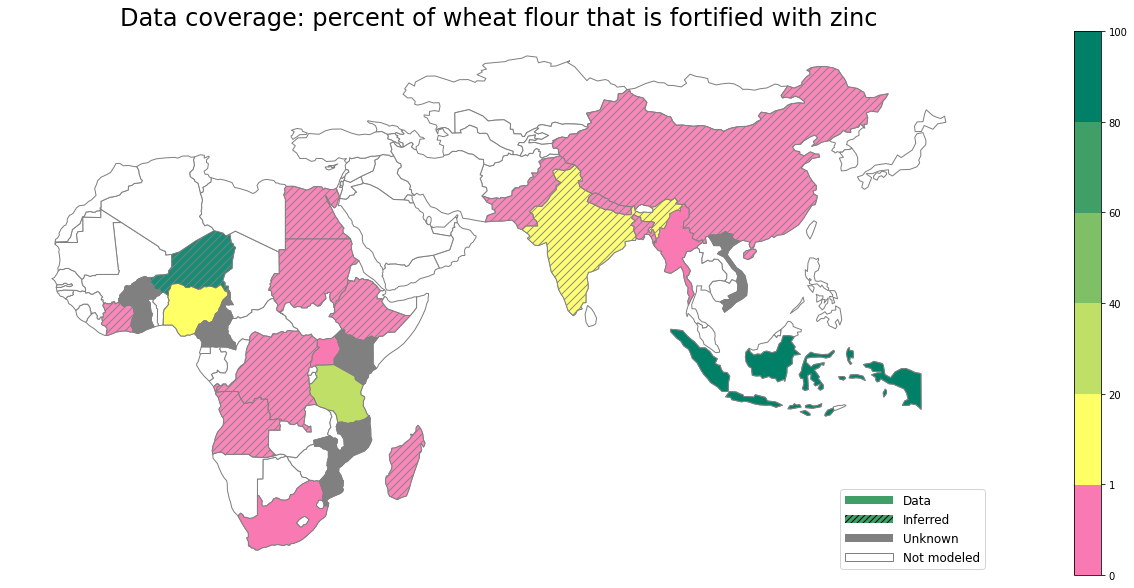

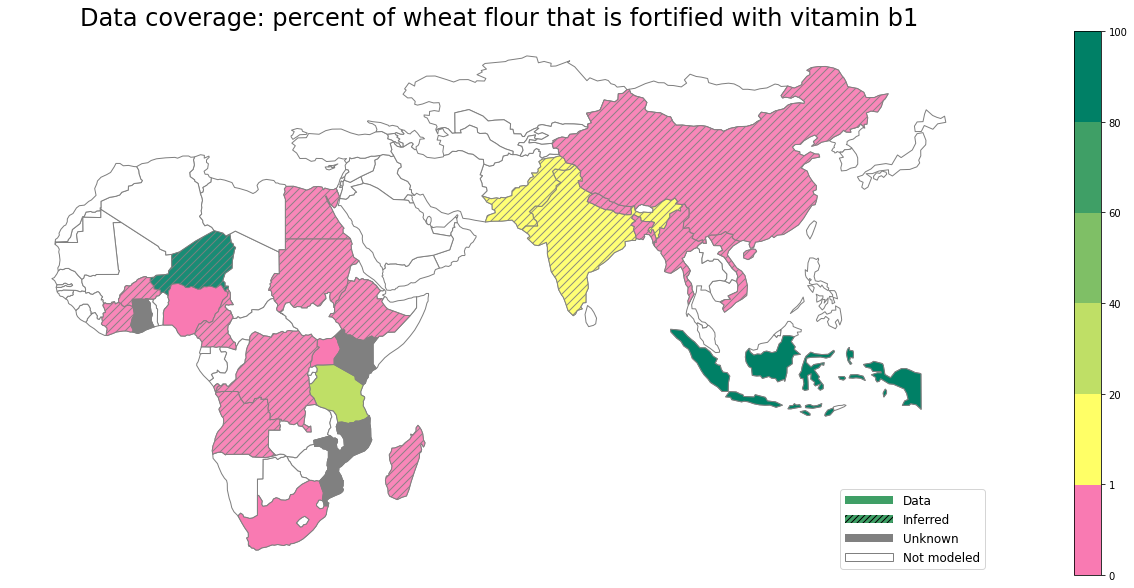

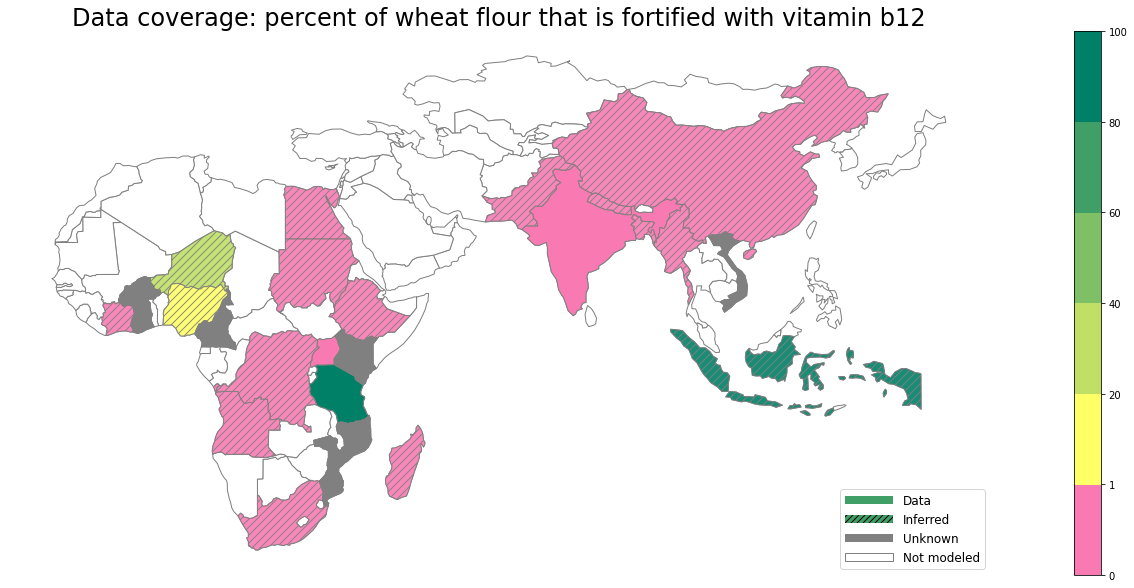

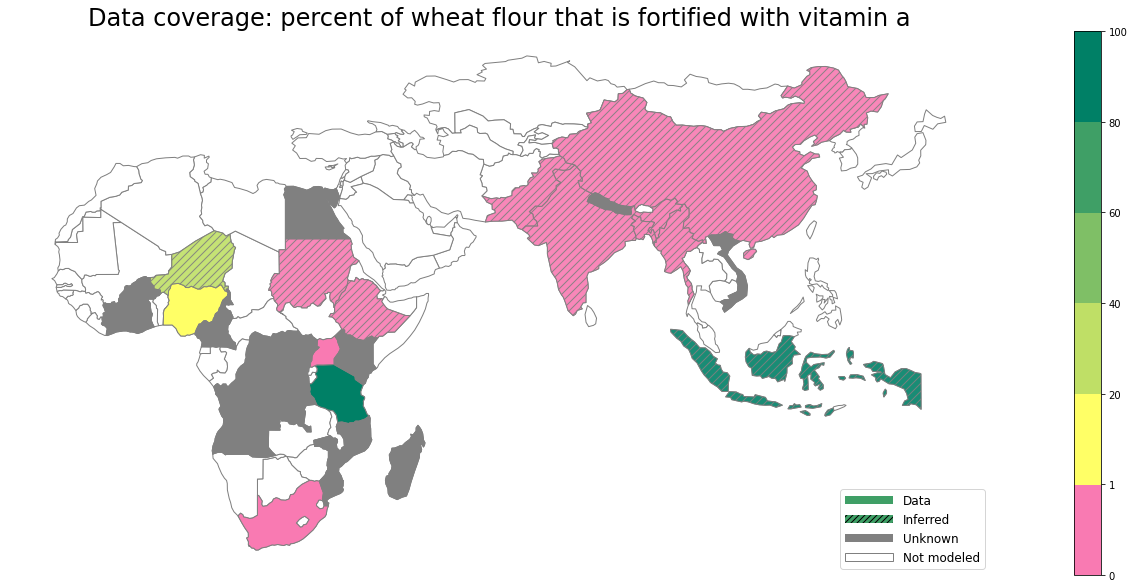

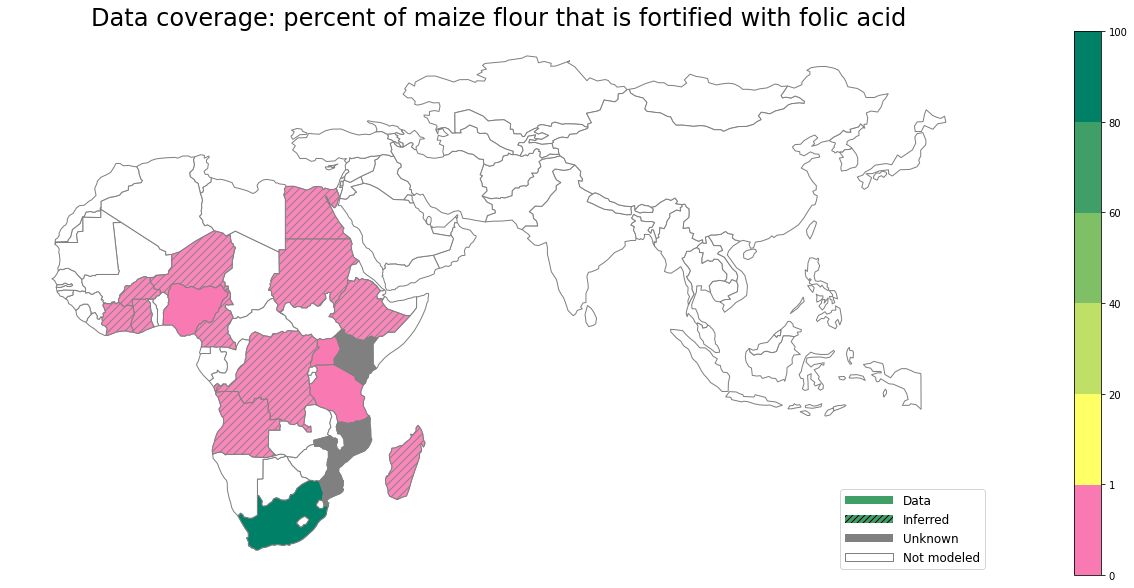

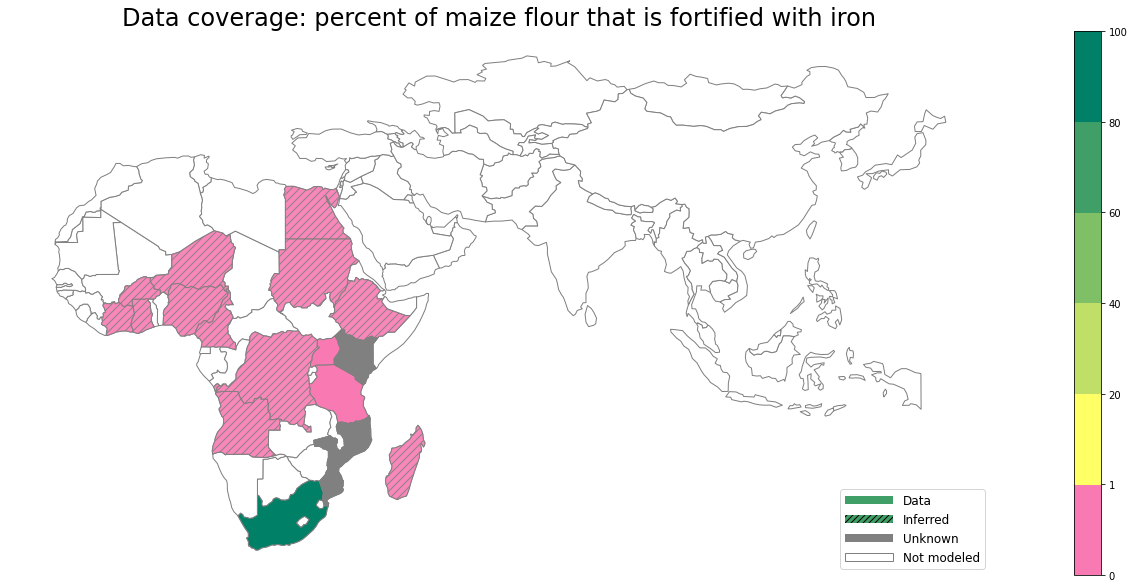

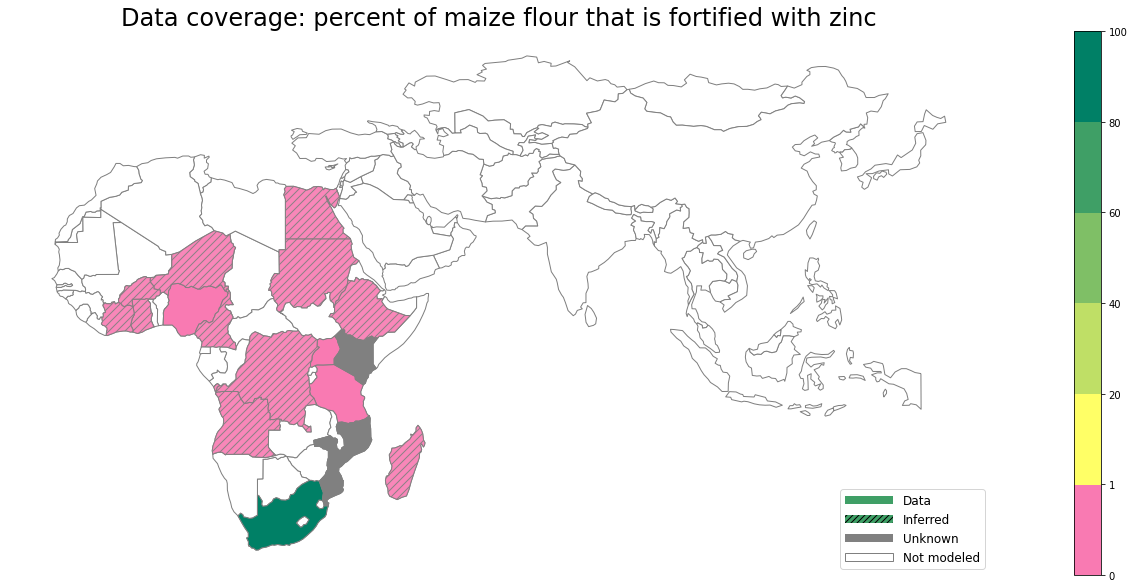

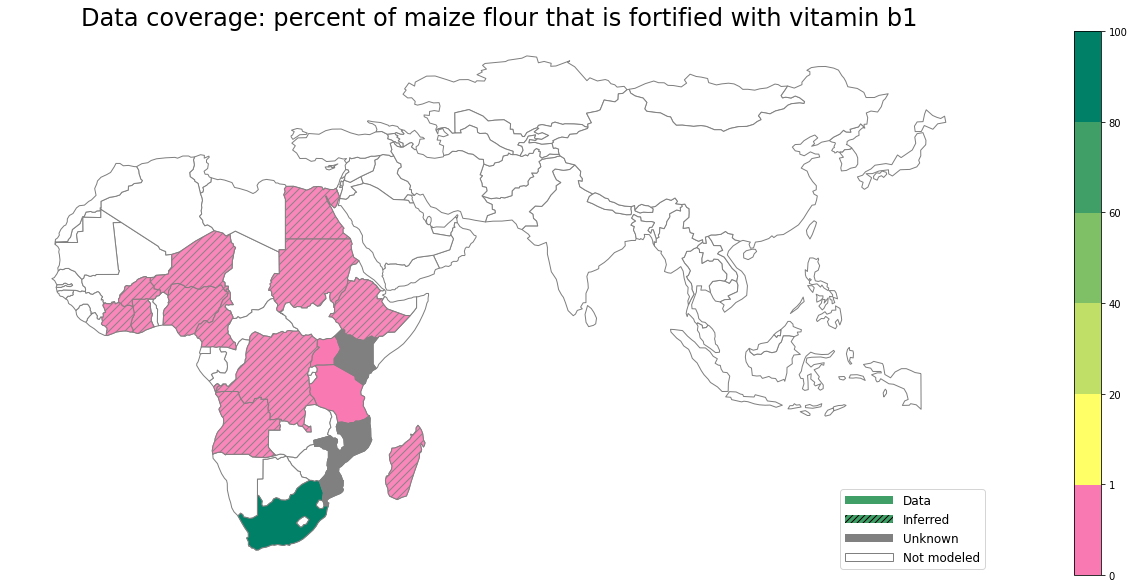

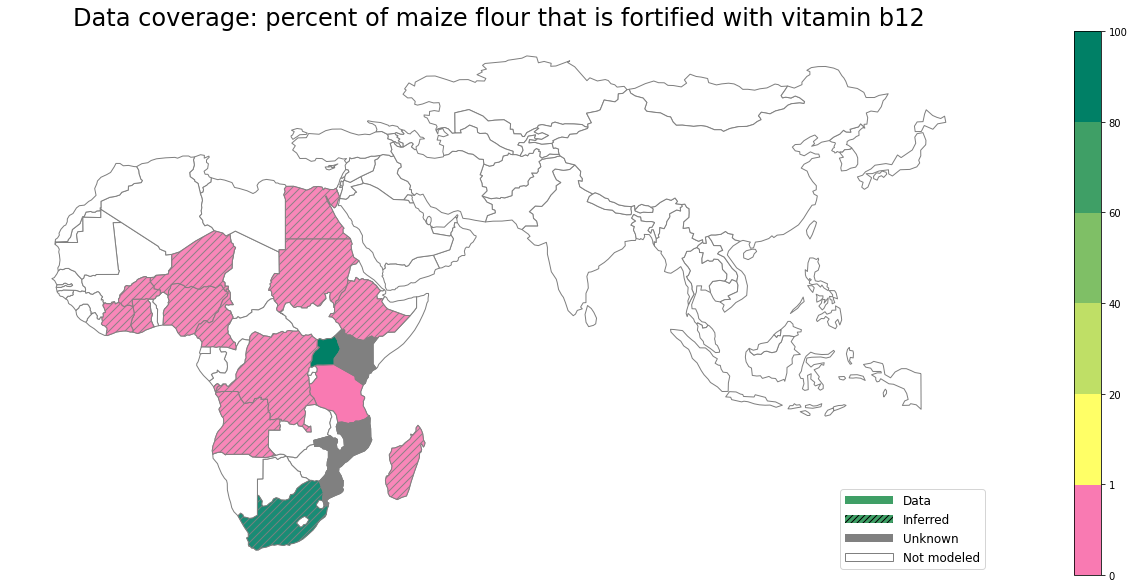

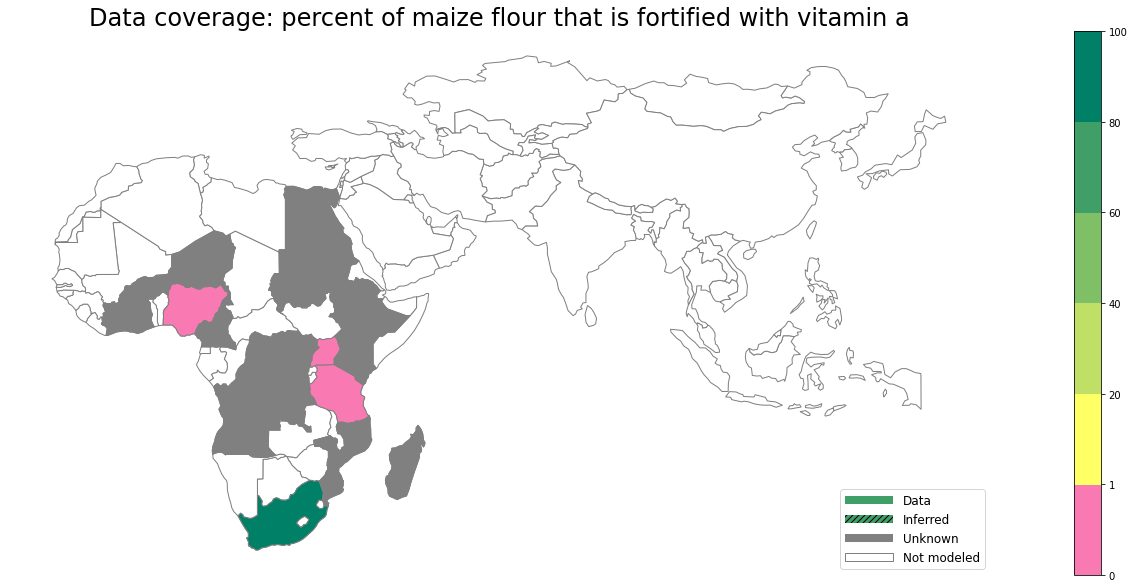

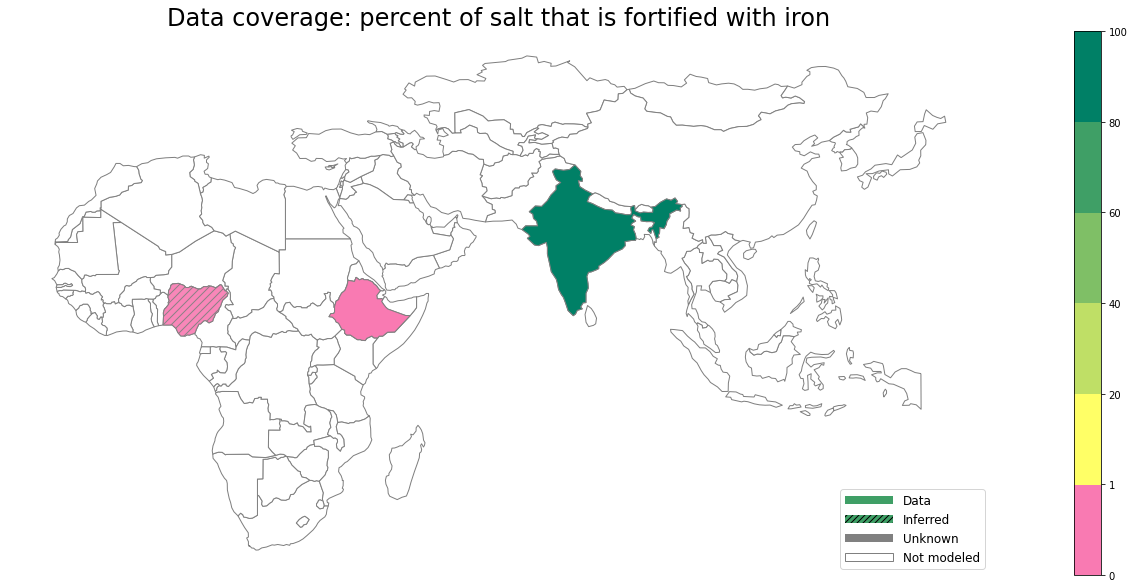

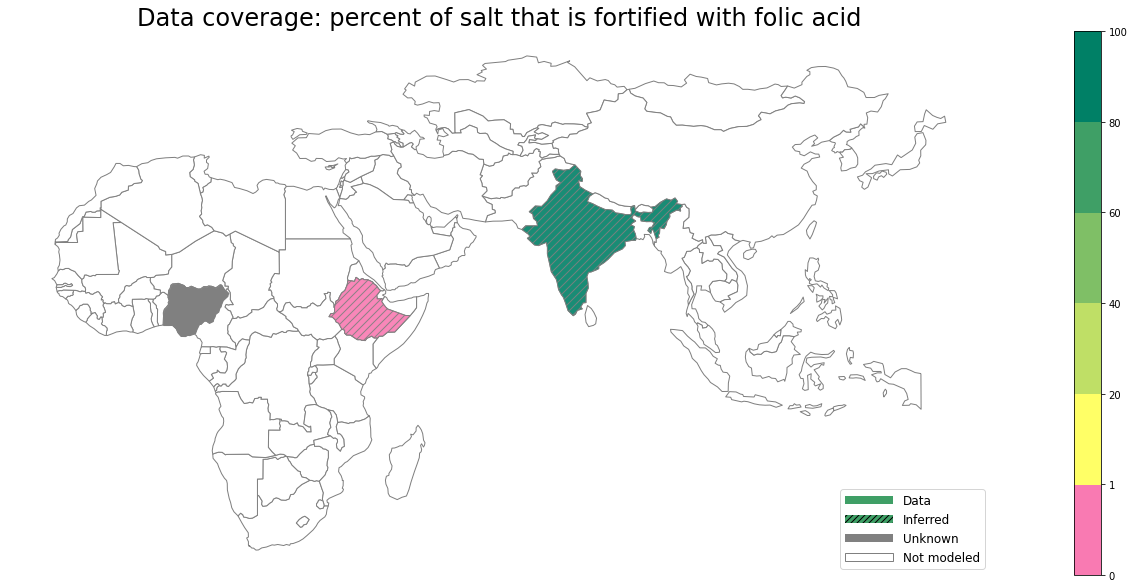

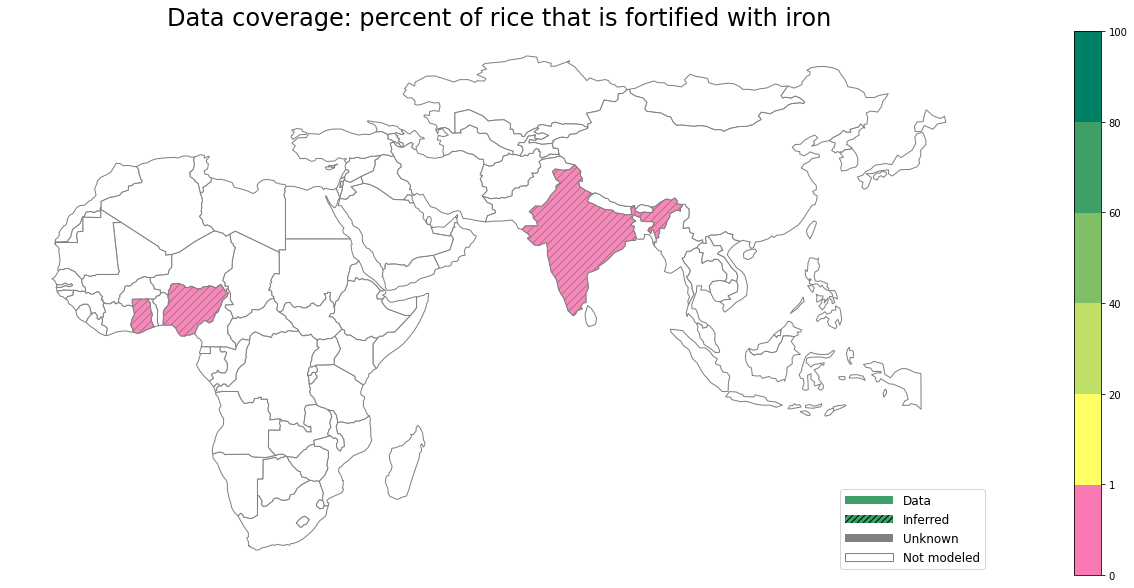

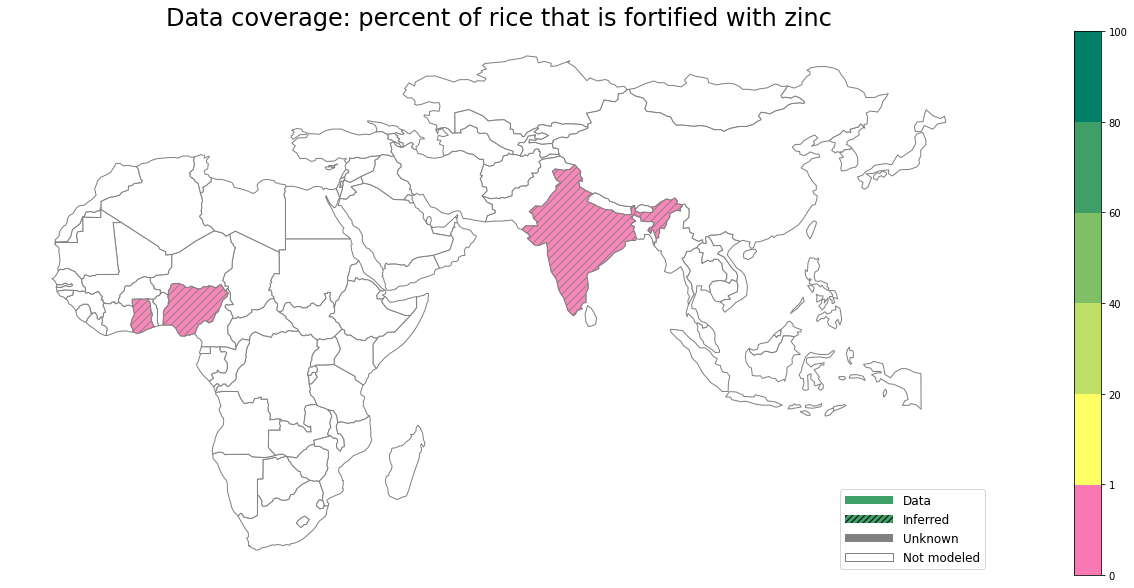

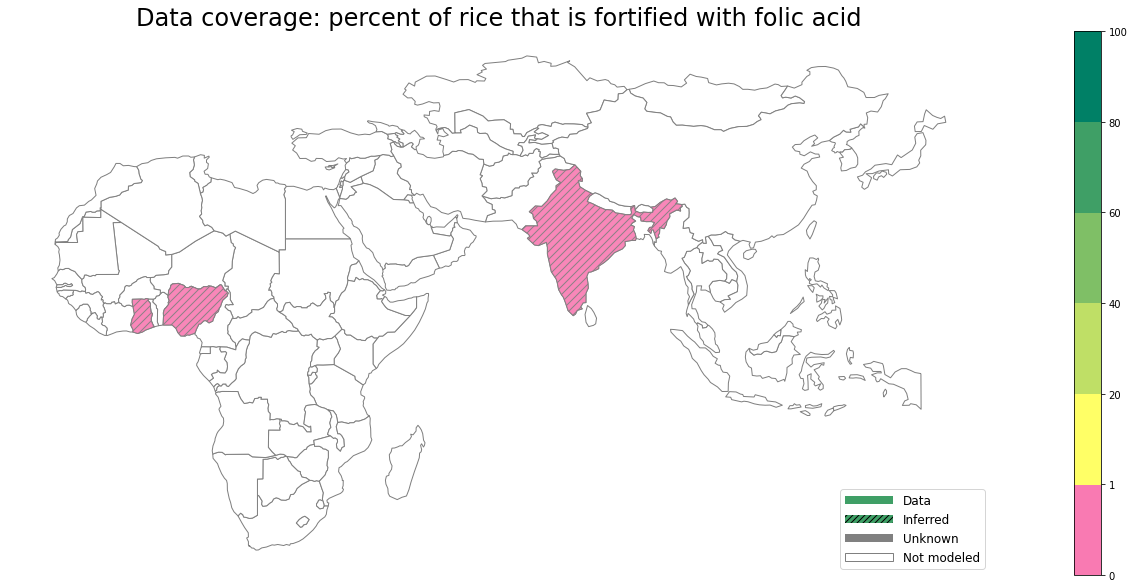

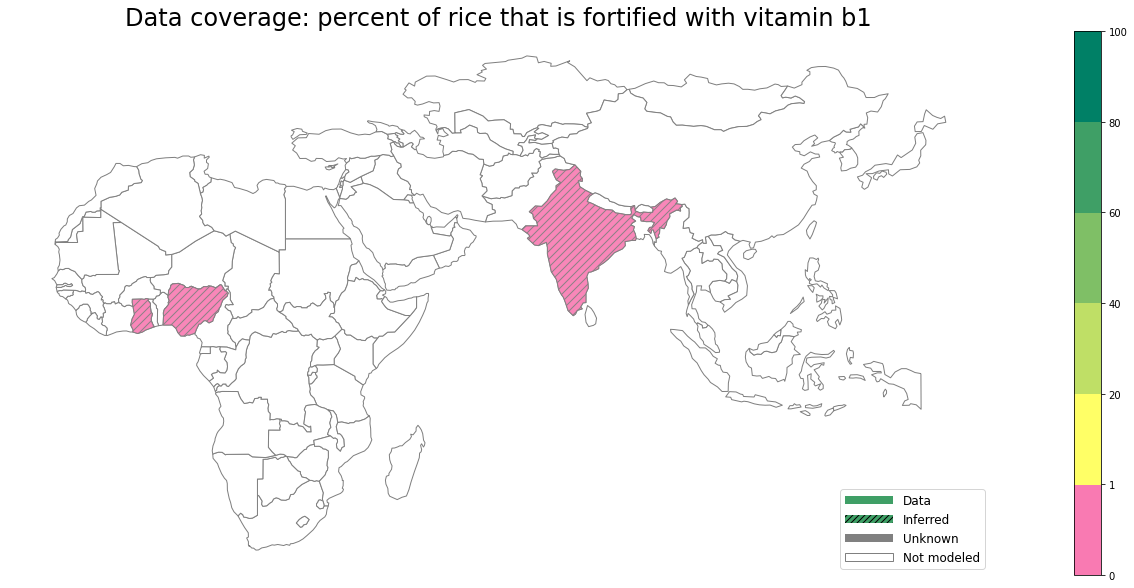

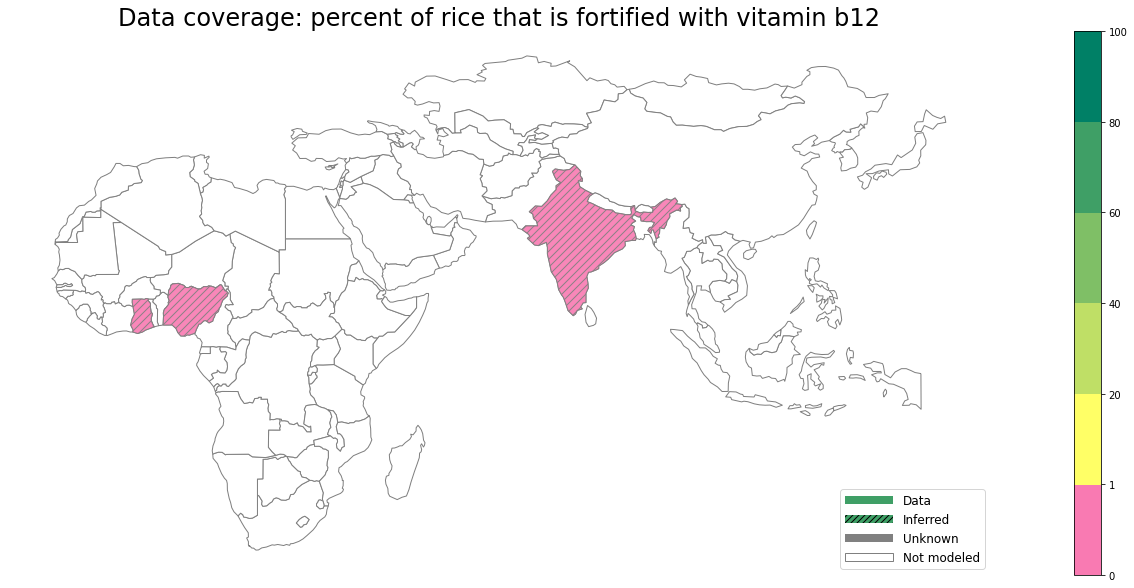

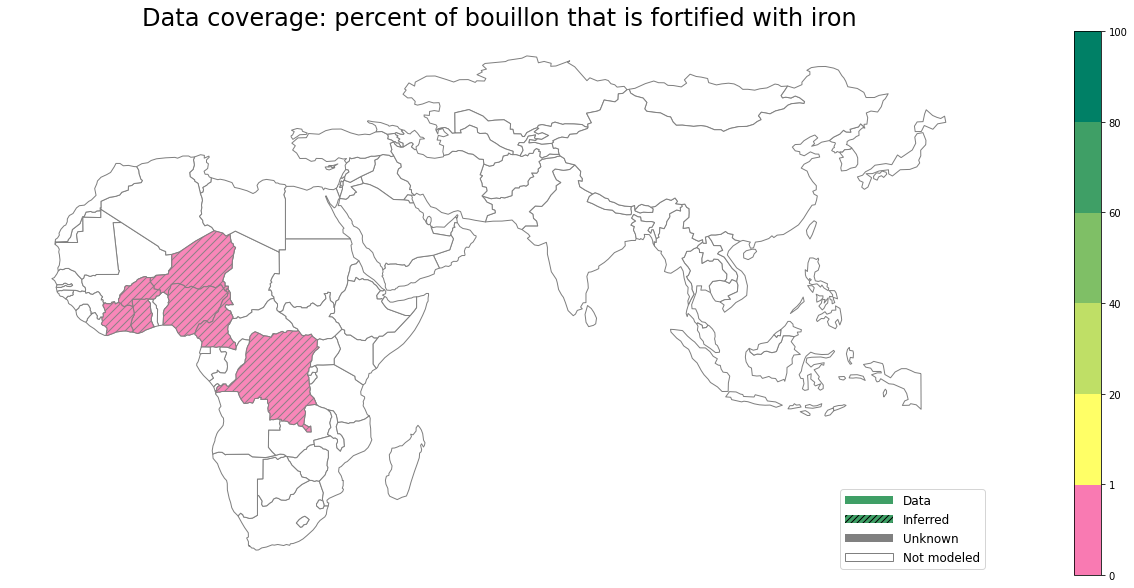

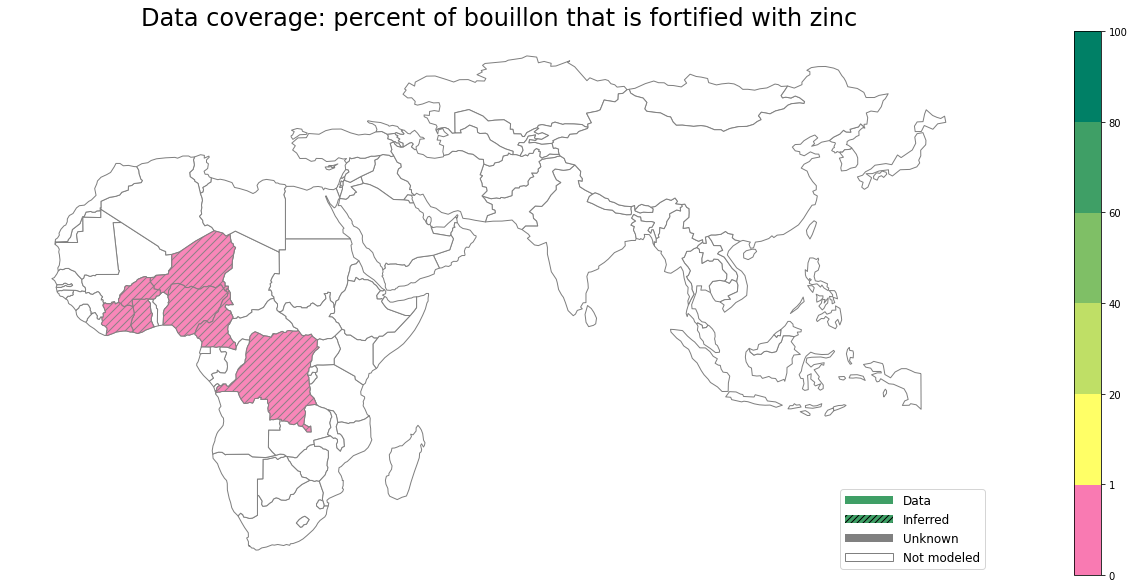

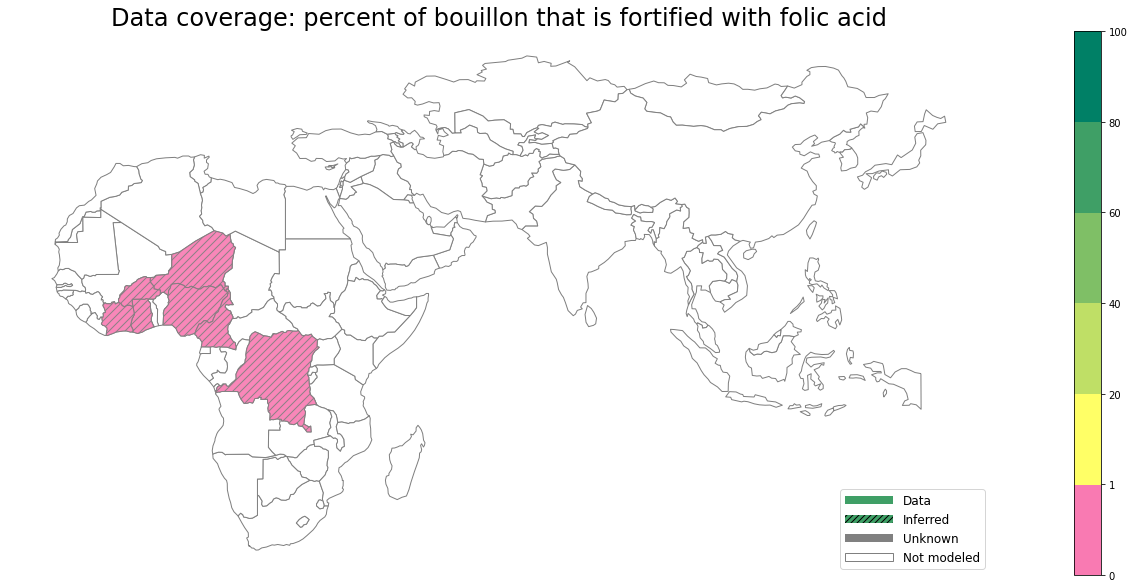

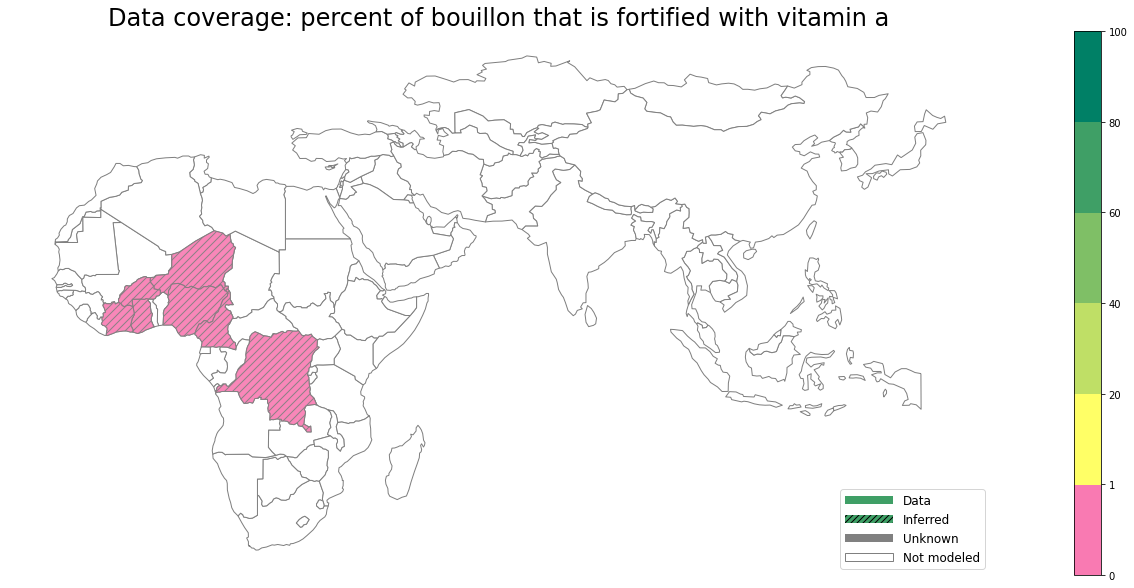

In [139]:
n_colors = 6
value_d = 'percent of population eating fortified vehicle'
for vehicle in vehicle_country_map.keys():
    vehicle_name = vehicle.replace(" ","_")
    save_path = f'/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/outputs/plots/viv_model_input_data_coverage/pct_pop_eating_fortified_{vehicle_name}.pdf'
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    
    for nutrient_i in vehicle_nutrient_map[vehicle]:
        fig = map_data_coverage(value_d, vehicle, nutrient_i, n_colors)
        pdf.savefig(fig)
    pdf.close()